> Installing required packages...

In [ ]:
²!pip install tensorflow
!pip install tensorflowjs
!pip install numpy
!pip install matplotlib
!pip install rarfile
!pip install sklearn

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import os

In [ ]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

> Checking if GPU device is linked.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
    
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


> Connecting with google drive to import training Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import rarfile

with rarfile.RarFile("/content/drive/MyDrive/Datasets/gol_data.rar", "r") as zip_ref:
  zip_ref.extractall("gol_data")

In [ ]:
data = []

with open("gol_data/gol_data_1.json", "r") as f:
    data.extend(json.load(f))

In [ ]:
start_all, stop_all = [], []

for item in data:
  start_all.append(item["start_gen"])
  stop_all.append(item["stop_gen"])

In [ ]:
print(len(start_all), len(stop_all))
print(len(start_all[1]), len(stop_all[0]))

100000 100000
625 625


> Splitting data to 66% training data and 33% testing data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(start_all, dtype="float32").reshape((-1, 25, 25, 1)), 
    np.array(stop_all, dtype="float32").reshape((-1, 25, 25, 1)), 
    test_size=0.33,
    random_state=42,
    shuffle=True)

> Creating the model with one hidden layer which is a convolutional layer of 4 filters.

In [ ]:
def CreateModel():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation="relu", padding="same", input_shape=(25, 25, 1)))
    model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation="relu", padding="same"))
    return model

> Compiling the model and starting the training

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/model_checkpoint_gol",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


with tf.device("/gpu:0"):
  Model = CreateModel()

  Model.compile(
      loss="bce",
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"])
  
  Model.summary()
  
  history = Model.fit(x=X_train,
                      y=Y_train,
                      epochs=200,
                      batch_size=512,
                      validation_data=(X_test, Y_test),
                      shuffle=True,
                      callbacks=[model_checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 1)         37        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
131/131 [==============================] - 3s 8ms/step - loss: 0.4872 - accuracy: 0.8501 - val_loss: 0.2652 - val_accuracy: 0.8449
INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint_gol/assets
Epoch 2/200
131/131 [==============================] - 1s 6ms/step - loss: 0.2577 - accuracy: 0.8452 - val_loss: 0.2466 - val_accuracy: 0.8461
INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint_gol/assets
Epoch 3/200
131/131 [==============================] - 1s 5ms/

In [ ]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 1)         37        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


> Loading the model.

In [ ]:
Model = tf.keras.models.load_model("/content/drive/My Drive/model_checkpoint_gol")

> Model performs very well with 100% acurracy on both testing and training data.
> The model learned successfully to replicate conway's game of life rules using only one hidden layer with 3x3 kernel of 4 filters which makes a total of 77 parameters to tune.

In [ ]:
Model.evaluate(X_test, Y_test)

1032/1032 [==============================] - 2s 2ms/step - loss: 1.4999e-10 - accuracy: 1.0000


[1.4998752240202862e-10, 1.0]

The model stopped training after 25 epochs and reached 100 % accuracy. The remaining training epochs lowered the Loss which was not useful for this Model.

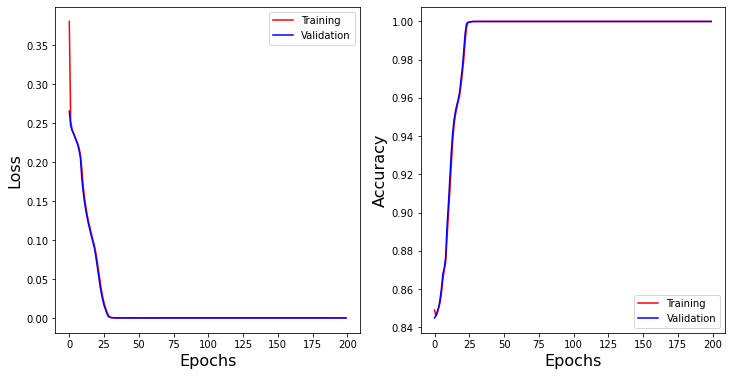

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

> Printing some samples from the data to visualize model predictions

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000


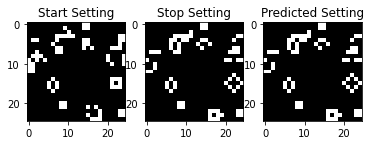

1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


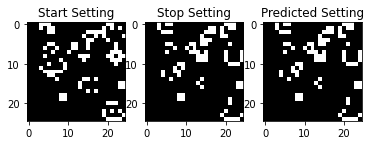

1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


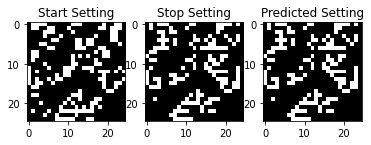

1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


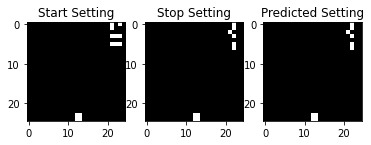

1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


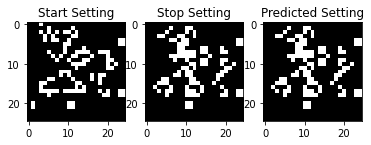

In [ ]:
for example in range(50, 55):

    img_sample = X_test[example]
    out_sample = Y_test[example]

    Model.evaluate(img_sample.reshape((-1, 25, 25, 1)), out_sample.reshape((-1, 25, 25, 1)))
    predicted = Model.predict(X_test[example].reshape((-1, 25, 25, 1)))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow((img_sample.reshape(25, 25)), cmap="gray")
    ax1.set_title("Start Setting")

    ax2.imshow((out_sample.reshape(25, 25)), cmap="gray")
    ax2.set_title("Stop Setting")

    ax3.imshow((predicted.reshape(25, 25) >= 0.5), cmap="gray")
    ax3.set_title("Predicted Setting")
    plt.show()